# Feature Engineering
This notebook documents the feature engineering process for the Fraud Detection project, focusing on the E-commerce dataset.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_palette('viridis')

# Load cleaned data
fraud_df = pd.read_csv('../data/processed/Fraud_Data_cleaned.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

print(f"Fraud Data Shape: {fraud_df.shape}")
print(f"IP Mapping Shape: {ip_df.shape}")


Fraud Data Shape: (1000, 11)
IP Mapping Shape: (4, 3)


## 1. Geolocation Integration
Mapping IP addresses to countries using range-based lookup.

In [2]:
# Convert IP to int64 for range matching
fraud_df['ip_address'] = fraud_df['ip_address'].astype(np.int64)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(np.int64)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(np.int64)

# Sort for merge_asof
fraud_df = fraud_df.sort_values('ip_address')
ip_df = ip_df.sort_values('lower_bound_ip_address')

# Merging using asof (matches where ip_address >= lower_bound)
df_merged = pd.merge_asof(
    fraud_df, 
    ip_df, 
    left_on='ip_address', 
    right_on='lower_bound_ip_address'
)

# Validate upper bound
df_merged['country'] = np.where(
    df_merged['ip_address'] <= df_merged['upper_bound_ip_address'],
    df_merged['country'],
    'Unknown'
)

# Drop intermediate artifacts
df_merged = df_merged.drop(['lower_bound_ip_address', 'upper_bound_ip_address'], axis=1)
df_merged.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,846,2015-02-05 15:00:00,2015-02-05 18:47:11,69,DEVICE45,Direct,Firefox,F,61,100135531,0,United States
1,348,2015-01-15 21:00:00,2015-01-16 17:36:47,91,DEVICE47,Direct,Safari,F,37,102089250,0,United States
2,493,2015-01-21 22:00:00,2015-01-22 10:49:22,98,DEVICE42,SEO,Chrome,M,34,108572896,0,United States
3,972,2015-02-10 21:00:00,2015-02-11 05:01:15,46,DEVICE21,Direct,Safari,F,23,112131224,1,United States
4,252,2015-01-11 21:00:00,2015-01-13 00:27:54,41,DEVICE1,Direct,Safari,F,29,118202353,0,United States


## 2. Feature Extraction
Adding time-based features and transaction velocity.

In [3]:
df_merged['signup_time'] = pd.to_datetime(df_merged['signup_time'])
df_merged['purchase_time'] = pd.to_datetime(df_merged['purchase_time'])

# 2.1 Time since signup
df_merged['time_since_signup'] = (df_merged['purchase_time'] - df_merged['signup_time']).dt.total_seconds()

# 2.2 Time-of-day and Day-of-week
df_merged['hour_of_day'] = df_merged['purchase_time'].dt.hour
df_merged['day_of_week'] = df_merged['purchase_time'].dt.dayofweek

# 2.3 Transaction frequency (Velocity)
df_merged['user_id_count'] = df_merged.groupby('user_id')['user_id'].transform('count')
df_merged['device_id_count'] = df_merged.groupby('device_id')['device_id'].transform('count')

df_merged.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_since_signup,hour_of_day,day_of_week,user_id_count,device_id_count
0,846,2015-02-05 15:00:00,2015-02-05 18:47:11,69,DEVICE45,Direct,Firefox,F,61,100135531,0,United States,13631.0,18,3,1,20
1,348,2015-01-15 21:00:00,2015-01-16 17:36:47,91,DEVICE47,Direct,Safari,F,37,102089250,0,United States,74207.0,17,4,1,20
2,493,2015-01-21 22:00:00,2015-01-22 10:49:22,98,DEVICE42,SEO,Chrome,M,34,108572896,0,United States,46162.0,10,3,1,20
3,972,2015-02-10 21:00:00,2015-02-11 05:01:15,46,DEVICE21,Direct,Safari,F,23,112131224,1,United States,28875.0,5,2,1,20
4,252,2015-01-11 21:00:00,2015-01-13 00:27:54,41,DEVICE1,Direct,Safari,F,29,118202353,0,United States,98874.0,0,1,1,20


## 2.4 Exploratory Visualization
Visualizing the impact of engineered features on fraud.

C:\Users\dell\AppData\Local\Temp\ipykernel_21596\2874762196.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_fraud.index, y=hour_fraud.values, ax=axes[0, 1], palette='Blues_d')
C:\Users\dell\AppData\Local\Temp\ipykernel_21596\2874762196.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_fraud.index, y=day_fraud.values, ax=axes[1, 0], palette='Reds_d')
C:\Users\dell\AppData\Local\Temp\ipykernel_21596\2874762196.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
C:\Users\dell\AppData\Local\Temp\ipykernel_21596\2

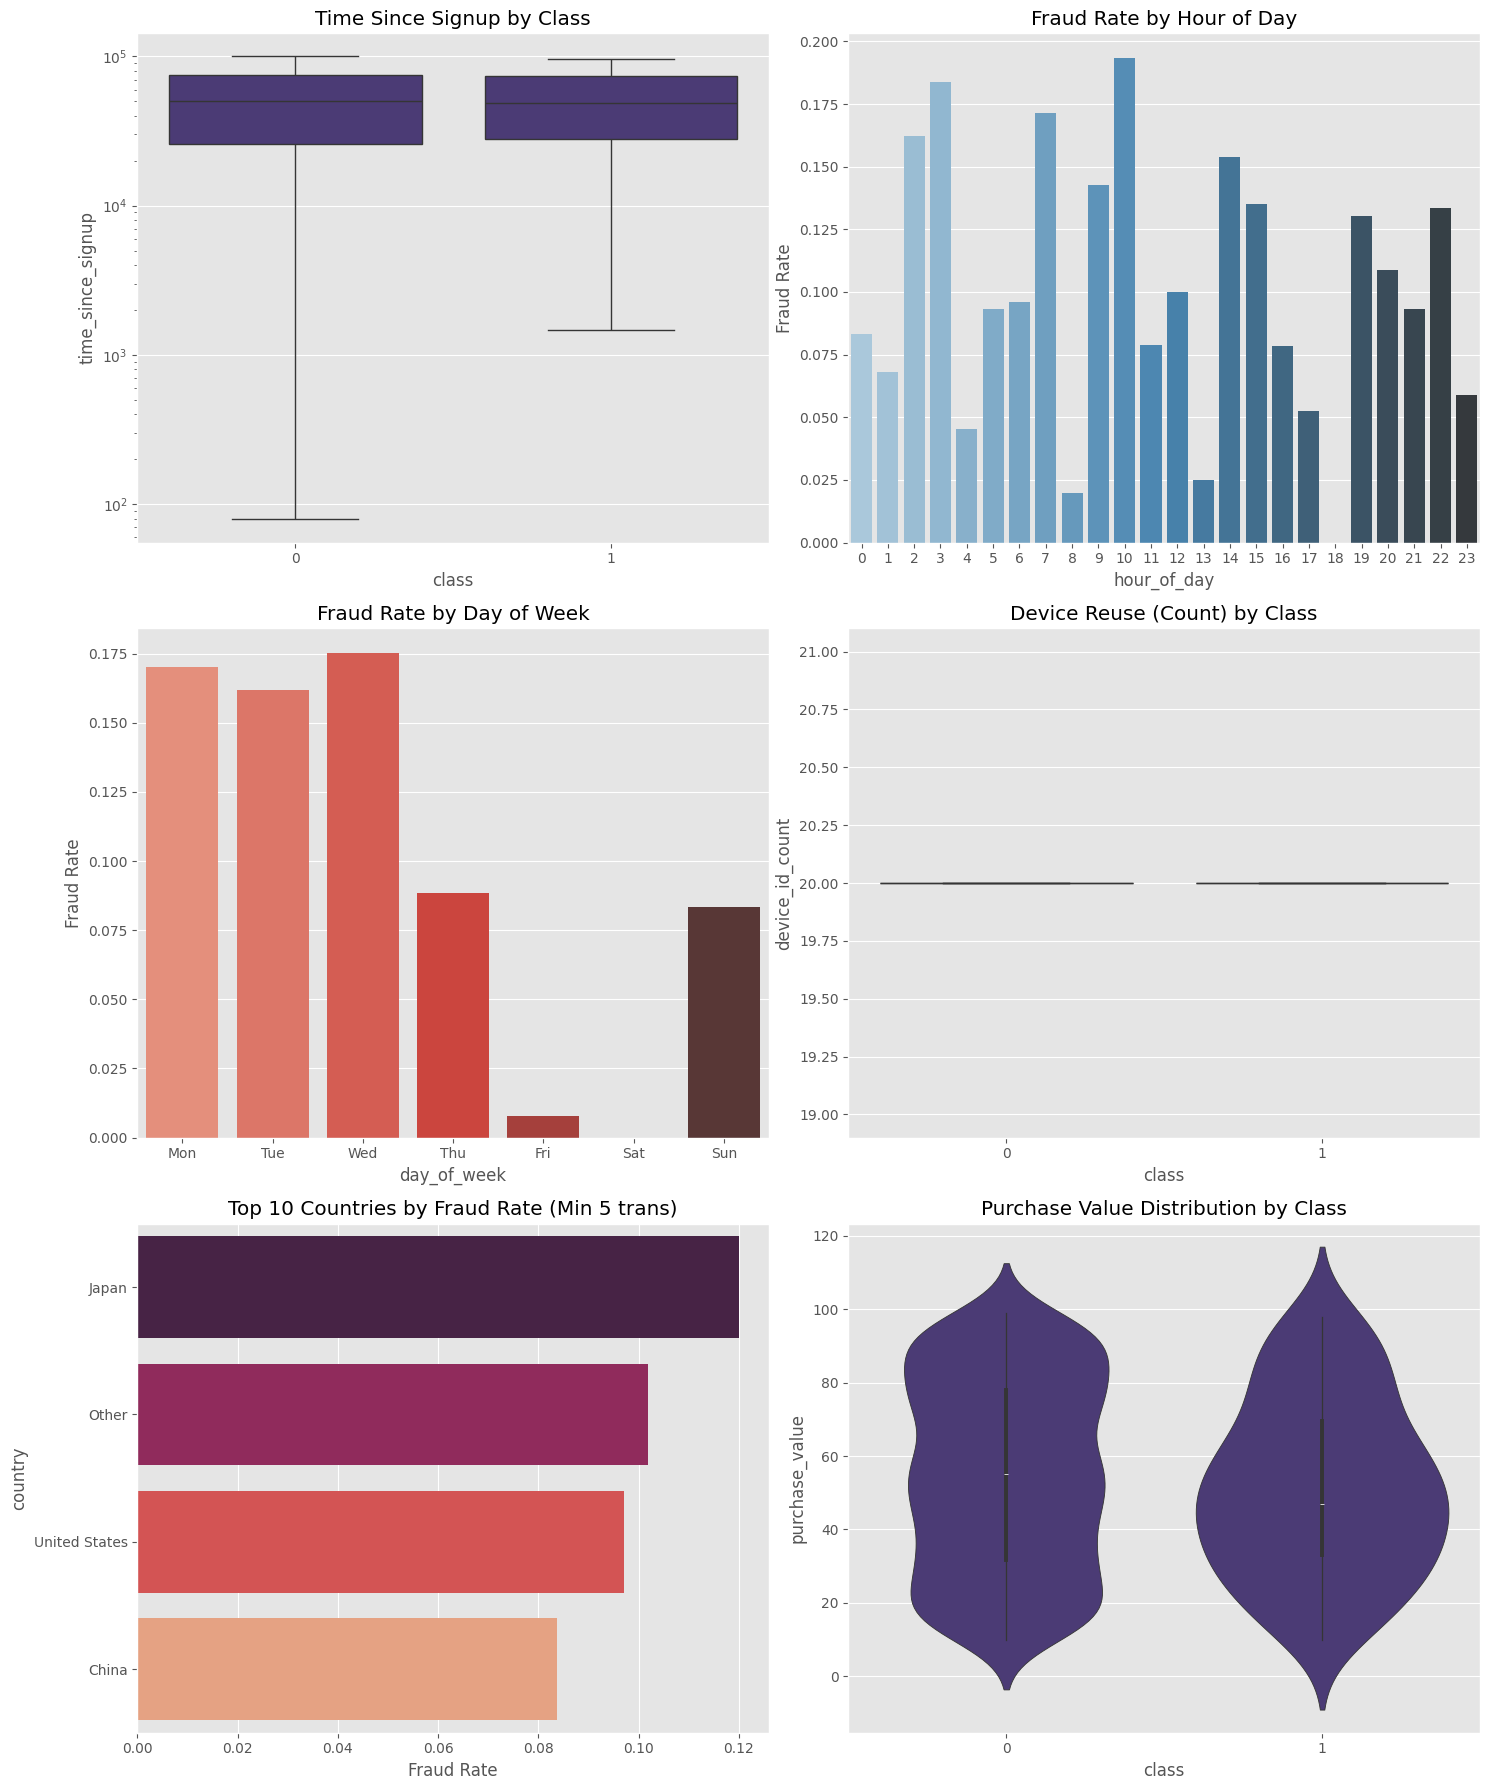

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
plt.subplots_adjust(hspace=1.5)

# 1. Time since signup vs Class
sns.boxplot(x='class', y='time_since_signup', data=df_merged, ax=axes[0, 0])
axes[0, 0].set_title('Time Since Signup by Class')
axes[0, 0].set_yscale('log')

# 2. Fraud Rate by Hour of Day
hour_fraud = df_merged.groupby('hour_of_day')['class'].mean()
sns.barplot(x=hour_fraud.index, y=hour_fraud.values, ax=axes[0, 1], palette='Blues_d')
axes[0, 1].set_title('Fraud Rate by Hour of Day')
axes[0, 1].set_ylabel('Fraud Rate')

# 3. Fraud Rate by Day of Week
day_fraud = df_merged.groupby('day_of_week')['class'].mean()
sns.barplot(x=day_fraud.index, y=day_fraud.values, ax=axes[1, 0], palette='Reds_d')
axes[1, 0].set_title('Fraud Rate by Day of Week')
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].set_ylabel('Fraud Rate')

# 4. Device ID Count vs Class
sns.boxplot(x='class', y='device_id_count', data=df_merged, ax=axes[1, 1])
axes[1, 1].set_title('Device Reuse (Count) by Class')

# 5. Top 10 Countries by Fraud Rate (min 10 transactions)
country_stats = df_merged.groupby('country')['class'].agg(['mean', 'count'])
top_fraud_countries = country_stats[country_stats['count'] > 5].sort_values('mean', ascending=False).head(10)
sns.barplot(x=top_fraud_countries['mean'], y=top_fraud_countries.index, ax=axes[2, 0], palette='rocket')
axes[2, 0].set_title('Top 10 Countries by Fraud Rate (Min 5 trans)')
axes[2, 0].set_xlabel('Fraud Rate')

# 6. Purchase Value vs Class
sns.violinplot(x='class', y='purchase_value', data=df_merged, ax=axes[2, 1])
axes[2, 1].set_title('Purchase Value Distribution by Class')

plt.tight_layout()
plt.show()

## 3. Save Processed Data
Saving the output for the transformation step.

In [5]:
os.makedirs('../data/processed', exist_ok=True)
df_merged.to_csv('../data/processed/Fraud_Data_features.ipynb_output.csv', index=False)
print("Feature engineering complete. Data saved.")

Feature engineering complete. Data saved.
